In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import expm, solve_continuous_are
import math

# the library requires "optional" dependencies not available in pip for almost all basic functions, 
# but plotting for zonotopes with a small amount of generators works fine.
# Plotting Zonotopes is the only intended use in the tutorial!
# https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.488.5151&rep=rep1&type=pdf
!pip install pypolycontain
import pypolycontain as pp 

# shapely is used for collision checking. It might not necessarily refer to zonotopes
# but we can always transfer
# https://shapely.readthedocs.io/en/stable/manual.html
from shapely.geometry import box, Polygon, MultiPoint

# for the animations
from matplotlib.animation import FuncAnimation
from IPython.display import HTML


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


/home/alfonso/Git_workspace/DD2415-Safe-Robot-Planning-and-Control/venv/lib/python3.12/site-packages/pypolycontain/operations.py:23: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pydrake installed properly. Methods that rely on optimization may fail.")
/home/alfonso/Git_workspace/DD2415-Safe-Robot-Planning-and-Control/venv/lib/python3.12/site-packages/pypolycontain/conversions.py:19: UserWarning: WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.
  warnings.warn("WARNING: You don't have CDD package installed. Unable to visualize polytopes. You may still visualize zonotopes.")
/home/alfonso/Git_workspace/DD2415-Safe-Robot-Planning-and-Control/venv/lib/python3.12/site-packages/pypolycontain/conversions.py:32: UserWarning: You don't have pydrake installed properly. Methods that rely on optimization may fail.
  warnings.warn("You don't have pyd

# (C level) Reachability and object detection using zonotopes

In this part of the tutorial, we will apply the findings of the previous tutorial to a collision-avoidance scenario! Given that we can now compute the permissible space of an autonomous system of the form 

$ \dot{x}(t) = A x(t) + d(t) $

were $d(t)$ is a bounded disturbance (in the previous tutorial $u(t)$), we can check the check the collision of two systems when propagated through time. 
As such, we will subject a nominally stable object and a controllable 'robot' of the form

$ \dot{x}(t) = A x(t) + B u(t) + d(t)$

to a zonotope collision check. We will use LQR to stabilize the system subjected to our preferences!

# The Object
We consider a moving obstacle which might cause issues for the robot's planned trajectory. We consider the obstacle as a first order integrator system with an uncertain initial position, $\mathcal{N}(\mu,\sigma^2)$. What we do know is that the $x$ and $y$ coordinate of the system are normally distributed according to

$x_0 \sim \mathcal{N}(2.5,0.05)$

$y_0 \sim \mathcal{N}(-3.5,0.055)$

We will first prescribe a zonotope with 2 generators that most closely describes this multivariate Gaussian distribution in the 2 dimensional plane at a confidence interval of 90%.

The true initial position distribution takes a specific shape (ellipse!). We then wish to find the generators that generate a rectangle zonotope that most closely captures this distribution at 90% confidence!

Note that we wish to find the $z_p$ value that scales the standard deviation and captures the probability of laying inside a specific range of real numbers, centered at the mean $\mu$ according to

$ Pr[x \in [\mu-z_p \sigma, \mu+z_p \sigma]] = p$

Although **you should compute this $z_p$ value yourself**, to help you out, the value should be 1.64485.

[[-0.1807687  -0.06995514]
 [ 0.3359452   0.37870984]]


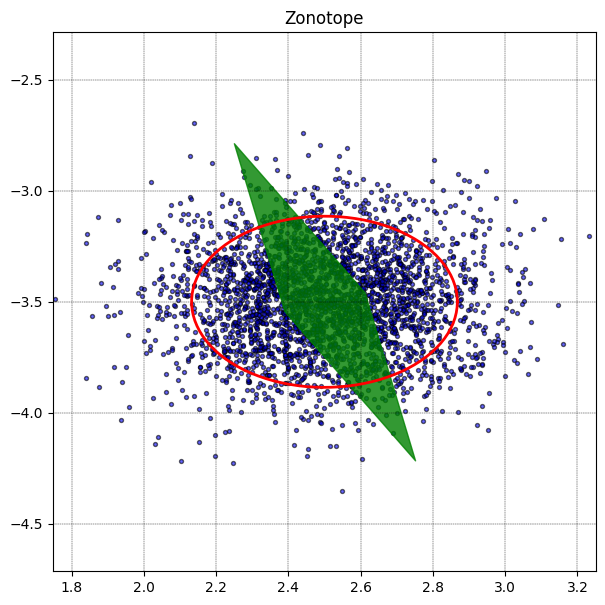

In [2]:
SigmaSquared = [0.05, 0.055]
Mu = [2.5, -3.5]

# The Distribution of the object
cov = np.array([[SigmaSquared[0], 0], [0, SigmaSquared[1]]])
points = np.random.multivariate_normal(Mu, cov, 3000)
x_points = points[:, 0]
y_points = points[:, 1]

# Ellipse
# general equation of an ellipse: (x/a)^2 + (y/b)^2 = s
# (x - ē)ᵀ E⁻¹ (x - ē) ≤ 1
# The probability of, from the positive domain w.r.t. mu,
# being in the 90 percent confidence interval
# https://en.wikipedia.org/wiki/Normal_distribution
z = 1.64485
major_axis = z * np.sqrt(SigmaSquared[0])
minor_axis = z * np.sqrt(SigmaSquared[1])
theta = np.linspace(0, 2 * np.pi, 100)
x_ellipse = Mu[0] + major_axis * np.cos(theta)
y_ellipse = Mu[1] + minor_axis * np.sin(theta)

# Zonotope    
n = 2 # number of dimensions
m = 2 # number of generators

# Find an enclosing 2D zonotope
# https://mediatum.ub.tum.de/doc/1554653/365916.pdf, 
# Page 5, Theorem 4 (Enclosing Zonotope)
# Shape matrix of the ellipsoid (symmetric positive definite)
E = np.array([[SigmaSquared[0] * z**2, 0], [0, SigmaSquared[1] * z**2]])

# Compute T = E^(-1/2) using eigendecomposition
# E=QΛQ^T => E^(-1/2) = QΛ^(-1/2)Q^T
eigenvalues, eigenvectors = np.linalg.eigh(E)
eigenvalues_sqrt = 1 / np.sqrt(eigenvalues)
T = eigenvectors @ np.diag(eigenvalues_sqrt) @ eigenvectors.T
T_inv = np.linalg.inv(T)

# Generate points on hypersphere in 2D
# It is easier to enclose the ellipse in a zonotope if the points are 
# mapped onto the surface of unit hypersphere.
# Lemma 4
points = np.random.randn(n, m)
S = points / np.linalg.norm(points, axis=0)

# Calculate l_hat = min(||S_i||^2)
# Lemma 5
# The lower bound of [Z(S, ·)]^2
l_hat = np.min(np.sum(S**2, axis=0))

# Calculate generator matrix G = (1/sqrt(l_hat)) * T^(-1) * S
c0 = Mu
g0 = (1/np.sqrt(l_hat)) * T_inv @ S
z0 = pp.zonotope(x=c0, G=g0)

print(g0)

# Plotting of the zonotope and the ellipse
fig, ax = plt.subplots()

ax.scatter(x_points, y_points, alpha=0.6, c='blue', marker='o', edgecolors='black', s=8)
ax.plot(x_ellipse, y_ellipse, color='red', linestyle='-', linewidth=2.0)
try:
  pp.visualize([z0], title='Zonotope', fig=fig, ax=ax)
except:
  pass

fig.set_size_inches(7, 7)

Now, let's take a step back and first generalize the results from the previous part into a function. Given some input data (see below), we want a function that returns the list of zonotopes. 

This mostly involves using the code from the previous part and turning it into a function.

In [3]:
def get_zonotopes(A,mu,c0,g0,t,r,color='g',simplify=False):

  # where
  # A: system matrix
  # mu: bounded disturbance
  # c0: initial condition
  # g0: initial generators
  # t: total simulation time
  # r: duration of time-step
  # color: the color of the zonotopes, helps distinguishing later on
  # simplify: do we lower the order of the zonotopes? (already with 2 generators so not always necessary)

  n = int(t/r)
  print(n)

  A_norm = np.linalg.norm(A, np.inf)
  e_ra = np.array(expm(r*A))

  sup_ig = max(np.linalg.norm(g, np.inf) for g in g0.T) # iterate over columns, which are the generators of  the initial zonotope
  alpha = (np.exp(r*A_norm) - 1 - r*A_norm) * sup_ig
  beta = ((np.exp(r*A_norm) - 1) / A_norm) * mu

  beta_box_g = np.array([[beta, 0], [0, beta]]).reshape(2, 2)
  alpha_beta_box_g = np.array([[alpha+beta, 0], [0, alpha+beta]]).reshape(2, 2)

  p0_c = (c0 + e_ra @ c0) / 2
  p0_g = np.zeros((2, 2 * g0.shape[1] + 1))
  for i in range(g0.shape[1]):
    p0_g[:, i] = (g0[:, i] + e_ra @ g0[:, i]) / 2
    p0_g[:, g0.shape[1] + i] = (g0[:, i] - e_ra @ g0[:, i]) / 2
  p0_g[:, g0.shape[1]] = (c0 - e_ra @ c0) / 2
  
  q0_c = p0_c
  q0_g = np.hstack((p0_g, alpha_beta_box_g))

  q_g = []
  q_c = []
  q_c.append(q0_c)
  q_g.append(q0_g)

  for i in range(1, n):
    pi_c = e_ra @ q_c[i-1]
    pi_g = e_ra @ q_g[i-1]

    qi_c = pi_c
    qi_g = np.hstack((pi_g, beta_box_g))

    q_c.append(qi_c)
    q_g.append(qi_g)

  zts = []
  for i in range(0, n):
    # reduction step by interval hull
    qi_g_reduced = np.zeros((2, 2))
    for index, row in enumerate(q_g[i]):
      qi_g_reduced[index, index] = np.sum(np.abs(row))
    
    zt = pp.zonotope(x=q_c[i], G=qi_g_reduced)
    # if simplify:
      # zt = pp.simplify_zonotope(zt)

    # add the reduced zonotope to the plot list
    zts.append(zt)

  return zts # return the zonotopes


Now let's call the function for the object and visualize our nominally stable trajectory! 

53


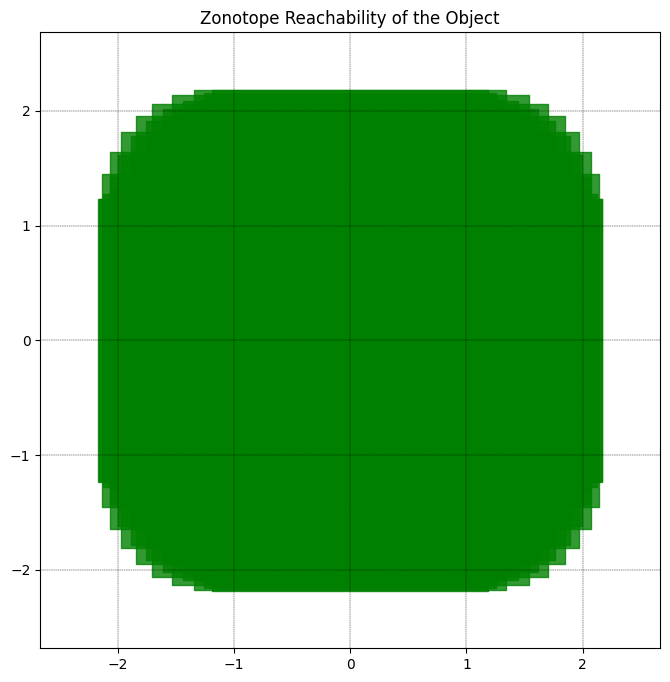

In [4]:
# duration of simulation
sim_duration = 4
r = 0.075
Ac = np.array([[1,-2],[2, -1]])
mu = 0.02 # note that this is the disturbance, not the mean

c0 = np.array([0,0])
g0 = np.array([[1,0],[0,1]])

zts_obj = get_zonotopes(Ac,mu,c0,g0,sim_duration,r)
fig, ax = plt.subplots()
try:
    pp.visualize(zts_obj, title='Zonotope Reachability of the Object', fig=fig, ax=ax)
except:
    pass
plt.show()


# The Robot!
Our robot model is given by a similar 2D single-integrator system. As mentioned, this is of the form

$ \dot{x}(t) = A x(t) + B u(t) + d(t)$

$ \begin{bmatrix} \dot{x} \\ \dot{y} \end{bmatrix} = \begin{bmatrix} -1 & 1 \\ -1 & 1 \end{bmatrix} \begin{bmatrix} x \\ y \end{bmatrix} + \begin{bmatrix} 1 & 0 \\ 0 & 1 \end{bmatrix} \begin{bmatrix} u_x \\ u_y \end{bmatrix} + d(t)$

which can be written in the desired autonomous form when a state-feedback control policy is applied. Our state-feedback will be obtained via [LQR](https://en.wikipedia.org/wiki/Linear%E2%80%93quadratic_regulator) which gives us an appropriate state-feedback controller given certain weights on the state deviation and the control input.

For our purposes, we wish to penalize both state-deviation and control input equally in the vertical and horizontal plane. In all situations, we do not penalize any cross-terms. For the state-deviation, we consider a weight of $50$ and for the control input a weight of $5$ respectively.

Below, implement the system and weight matrices and obtain the LQR closed-loop stabilized system by solving the continuous-time algebraic Ricatti equation using the `scipy` package. We then plot the zonotopes of the object and the robot in a single plot (use the color argument in your `get_zonotopes()` function!)

## Some intuition
While "solving the ARE" seems very arbitrary, the intuition is quite straightforward. Note that we have the optimization problem

$ \min(\int_0^{\infty} (x(t)^T Q x(t) + u(t)^T R u(t))dt )$

s.t. $\dot{x}(t) = Ax(t) + Bu(t)$

It turns out that it is easy to solve this problem as we have a quadratic cost and a linear system! The relevant steps are that we first pick a positive definite symmetric matrix $P = P^T$ and add two terms to the cost that cancel eachother out

$ x_0^T P x_0 - x_0^T P x_0 + \int_0^{\infty} (x(t)^T Q x(t) + u(t)^T R u(t))dt$

for which we can take $-x_0^T P x_0$ into the integral sign. Notice that $\frac{d}{dt}(x^T P x) = \dot{x}^T P x + x^T P \dot{x}$ and $\dot{x}$ is something we already know! We get terms that depend on $u$, terms that depend on $x$, and terms that depend on both. The optimization of this unconstrained problem is significantly easier under the assumption that the control input is applied according to $u = -R^{-1}B^TPx$. If you work out the math yourself, it will lead to a cost term where the only thing we can influence is the term $\int_0^{\infty} x^T (A^TP + PA + Q - PBR^{-1}B^TP)x$ for which the term between the state $x^T$ and $x$ is the ARE.

LQR is a valuable control tool as
- It considers an optimal trade-off between user specified system requirements
- It has inherent robustness!
- It has a strong theoretical foundation with an analytical solution!

which makes it a powerful and elegant tool. We will see however, that it is not so simple to address elements commonly found in safe planning and control with pure LQR...



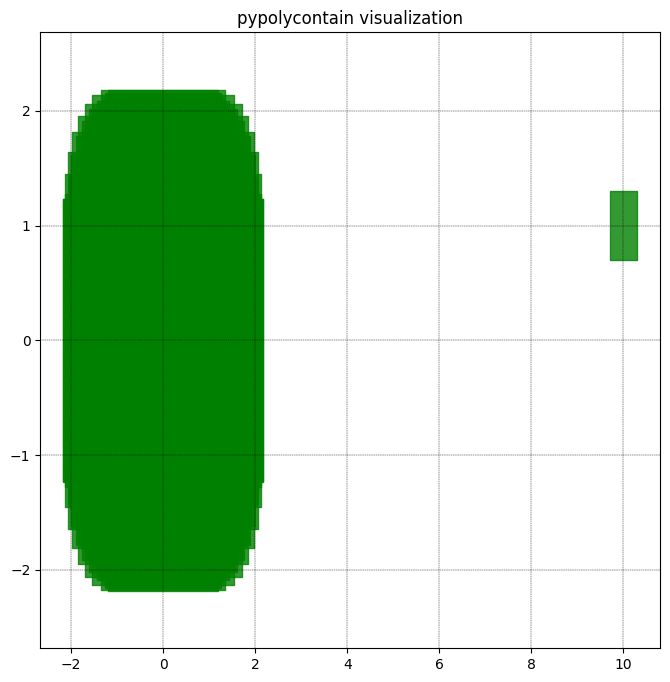

In [5]:
#PUT YOUR CODE HERE
A = np.array([[-1,1],[-1,1]])
B = np.array([[1,0],[0,1]])
Q = np.diag([120,55])
R = np.diag([5,5])
P = solve_continuous_are(A, B, Q, R)
K = np.linalg.inv(R) @ B.T @ P # N^T = 0

# closed-loop system
# ẋ(t) = Ax(t) + Bu(t), u(t) = -Kx(t)
# ẋ(t) = (A - BK)x(t)
Ac = A - B @ K

mu = 0.1
c0 = np.array([10,1])
g0 = np.array([[0.3,0],[0,0.3]])

zts_rob = pp.zonotope(x=c0, G=g0)
fig, ax = plt.subplots()
try:
    pp.visualize(np.append(zts_obj,zts_rob), fig=fig, ax=ax)
except:
    pass
plt.show()


Here's an animation function which should give you some indication of what is actually going on:

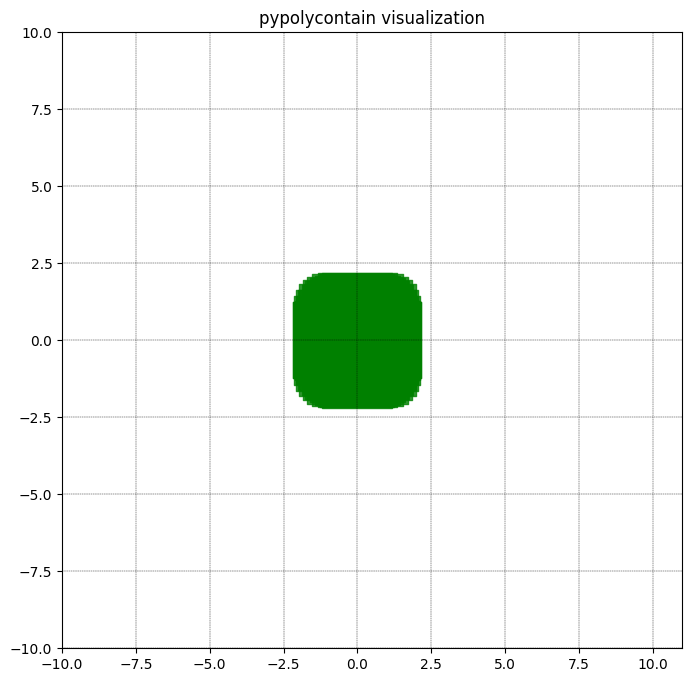

In [6]:
## ANIMATION FUNCTION
def animation_func(i,data):
  zts_obj = data[0]
  zts_rob = data[1]
  try:
    pp.visualize([zts_obj[i]], fig=fig, ax=ax)
  except:
    pass
  try:
    pp.visualize([zts_rob[i]], fig=fig, ax=ax)
  except:
    pass
  ax.set_xlim([-10, 11])
  ax.set_ylim([-10, 10])
  
fig = plt.figure()
ax = fig.add_subplot(111)
animation = FuncAnimation(fig,animation_func, fargs=((zts_obj,zts_rob),),
                          frames=len(zts_obj), interval=50, blit=False)
HTML(animation.to_html5_video())

# Collisions!

Given the fact that we limit ourselves to zonotopes with two generators, we can do a simple collision check on two rectangles. This involves checking overlap with 4 conditions given the center and height and width (or edge points) of the rectangles. 

Implement this very simple rectangle collision checker in a function:

In [7]:
def simple_collision_check(zts_obj,zts_rob):
  collision = False

  # Rob
  rob_top = zts_rob.G[1,0] + zts_rob.x[1]
  rob_bottom = zts_rob.x[1] - zts_rob.G[1,0]
  rob_left = zts_rob.x[0] - zts_rob.G[0,0]
  rob_right = zts_rob.x[0] + zts_rob.G[0,0]

  # Loop through all objects
  for obj in zts_obj:
    obj_top = obj.G[1,0] + obj.x[1]
    obj_bottom = obj.x[1] - obj.G[1,0]
    obj_left = obj.x[0] - obj.G[0,0]
    obj_right = obj.x[0] + obj.G[0,0]
    if (rob_top > obj_bottom and rob_bottom < obj_top and rob_left < obj_right and rob_right > obj_left):
      collision = True
      break

  if collision:
    print("Collision detected!")
  else:
    print("No collision detected!")
  
  return collision

simple_collision_check(zts_obj,zts_rob)

No collision detected!


False

However, this does not generalize to zonotopes with many more generators. A given is that regardless of how many generators a zonotope has, the shape is always convex! As such, we can check the collision via intersection of two convex polytopes which we will construct using shapely.geometry.Polygon.

We could of course check intersection by methods that explicitly rely on zonotopes (e.g. [this](https://graphics.stanford.edu/~anguyen/papers/zonotope.pdf)). You're free to implement these methods, yet using the shapely library suffices for now. We are going to use it later on as well.

Implement this more general collision checker in a function:

In [8]:
import itertools
def get_vertices(zonotope):
  center = np.array(zonotope.x)
  generators = np.array(zonotope.G)
  
  # Number of generators
  num_generators = generators.shape[1]
  
  # Generate all possible combinations of -1 and 1 for the generators
  combinations = list(itertools.product([-1, 1], repeat=num_generators))
  
  # Compute the vertices
  vertices = []
  for combination in combinations:
    vertex = center + np.dot(generators, combination)
    vertices.append(vertex)

  return np.array(vertices)

def polygon_collision_check(zts_obj,zts_rob):
  collision = False
  for zt_obj in zts_obj:
    poly_obj = Polygon(get_vertices(zt_obj))
    poly_rob = Polygon(get_vertices(zts_rob))
    if poly_obj.intersects(poly_rob):
      collision = True
      print("Collision detected!")
      break
  if not collision:
    print("No collision detected!")

#     # 1: get the vertices from the zonotope
#     # 2: convert the vertices into a shapely Polygon
# print whether a collision occured or not

polygon_collision_check(zts_obj,zts_rob)


No collision detected!


Seems like we're not in collision then! Check out why that is the case (do we pass the object before or after?) and change the terms in the LQR controller of the robot accordingly such that there is a collision. 
Although that is not necessarily behavior that we want to see here, it makes for a more interesting experience in the A-level section!

Note the old and new cost terms down somewhere!

# (A level) Collision! What to do now?
What you have been doing so far is often referred to as $\textit{verification}$ process since you are using the knowledge of your system to analyze whether some desired specification (do not collide with an obstacle) holds or not.

In the next couple of steps, you're gonna look into the so called $\textit{synthesis}$ process in which you are given a desired system specification and you design a control strategy $u$ such that the specification holds. Specifically, you're gonna design different Control Barrier Functions (CBFs) to guarantee that the robot stays within an obstacle-free safeset. CBFs have been covered in the lectures but if you would like to refresh your knowledge you might want to have a look at [this](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8796030&casa_token=CtgTXVjMhTAAAAAA:93TomzH638Rg17rJl9LRW5WYljATBuiBor0OkfvSXwvZ-Y0rO-xkOhK15JBWIqrcIDgnqlEX) publication.

# Simple yet provably safe controller
First, we will design a very conservative barrier function. In this case, we would like to obtain a halfspace constraint that contains all possible obstacle locations. If we can design a controller that stays within this obstacle-free halfspace, we are guaranteed to avoid collisions.


Such a halfspace can be defined as $\mathcal{H} = \left\{ x \in \mathbb{R}^n \mid a^T x \leq b\right\}$. Recall, that any polygon can also be written as an intersection of halfspaces. Convince yourself that the convex hull of all obstacle location from $t=0, \dots , T$ contains all possible locations the obstacle might be at. In the following, try to find this convex polygon and visualize it!

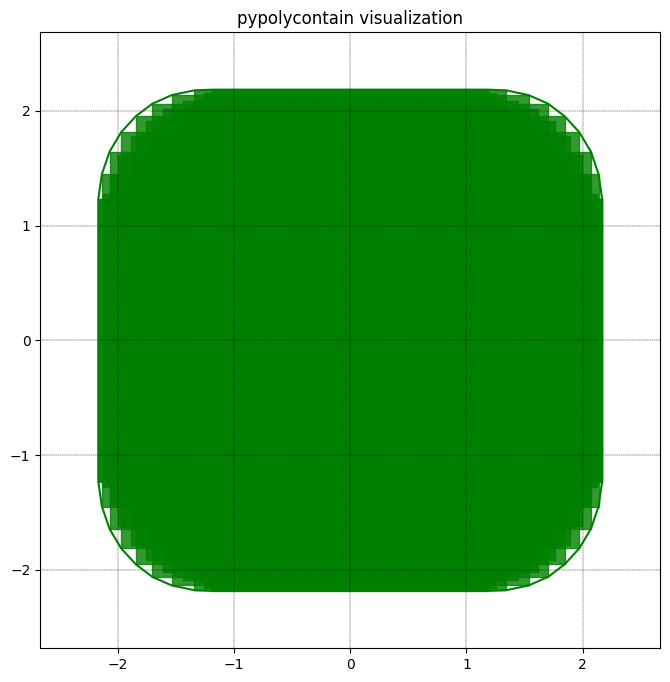

In [9]:
# trajectory of the obstacle in V-form
obj_trajectory = [pp.zonotope_to_V(zts_obj[i]).tolist()[j] for i in range(len(zts_obj)) for j in range(4)]

# convex hull of obstacle trajectory
conv_hull_obj = MultiPoint(obj_trajectory).convex_hull

# Visualization
x,y = conv_hull_obj.exterior.coords.xy

try:
    pp.visualize(zts_obj)
except:
    pass
plt.plot(x,y,'g')
plt.show()

Next, in order to define our barrier function, we need the convex hull of the obstacle trajectory in halfspace form (H-polytope). Unfortunatel, the function provided in `pypolycontain` does not work properly, so we have to do the conversion ourselves. Recall that each edge of the polytope between two consecutive vertices $V_i$ and $V_{i+1}$ can be described as a linear function of the form $a^T x - b = 0$.

Note, that the convex hull has many vertices, so we would like to create a list of tuples that contains all the halfspaces $halfspaces = [(a_0, b_0), \dots, (a_{N-1}, b_{N-1})]$ where $N$ is the number of vertices. Since it can be tideous to find the correct sign of the halfspaces, this function is provided in the following. Try to understand the code!

/tmp/ipykernel_331564/1682153685.py:16: RuntimeWarning: invalid value encountered in scalar divide
  a = [dy / abs(dx), -1]


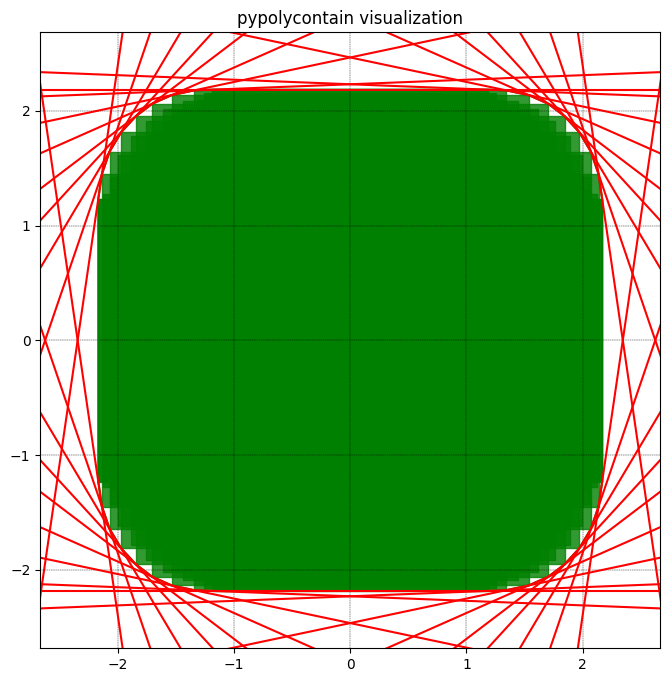

In [10]:
vertices = np.array([[x[i], y[i]] for i in range(len(x))])

def construct_halfspaces(vertices_list):
  halfspaces = []

  for i in range(len(vertices_list)-1):
    # vertex i
    p1 = vertices[i]
    # vertex i+1
    p2 = vertices[i+1]

    # change in x and y
    dx = p2[0] - p1[0]
    dy = (p2[1] - p1[1]) * np.sign(dx)

    a = [dy / abs(dx), -1]
    b = a[0] * p1[0] + a[1] * p1[1]
    if dx < 0:
      a = [-a[0], -a[1]]
      b *= -1
    halfspaces.append((a, b))

  return halfspaces

halfspaces = construct_halfspaces(vertices.tolist())

# visualize all the halfspaces
try:
  pp.visualize(zts_obj)
except:
  pass
plt.plot(x,y,'g')
for ab in halfspaces:
  plt.plot([-10,10], [(ab[1] - ab[0][0] * (-10)) / ab[0][1], (ab[1] - ab[0][0] * (10)) / ab[0][1]], 'r')
plt.show()


Now, any of these halfspaces could be used as a candidate CBF since the intersection of all halfspaces $\mathcal{O} = \left\{x \in \mathbb{R}^n \mid \bigwedge_{i=0}^{N-1} a_i^T x \leq b_i \right\}$ represents the obstacle region and, thus, if any of the halfspace constraints is violated, i.e. $\bigvee_{i=0}^{N-1} a_i^T x \geq b_i$, then the robot is outside of the obstacle region $\mathcal{O}$.

The question that remains is: Which one is the most suitable halfspace constraint? It's a design choice! We would like to obtain a halfspace that contains the initial position of the robot $x_0$ and allows us to get as close as possible to the goal $g = [0, 0]$. Hint: use the distance between a point and a line!

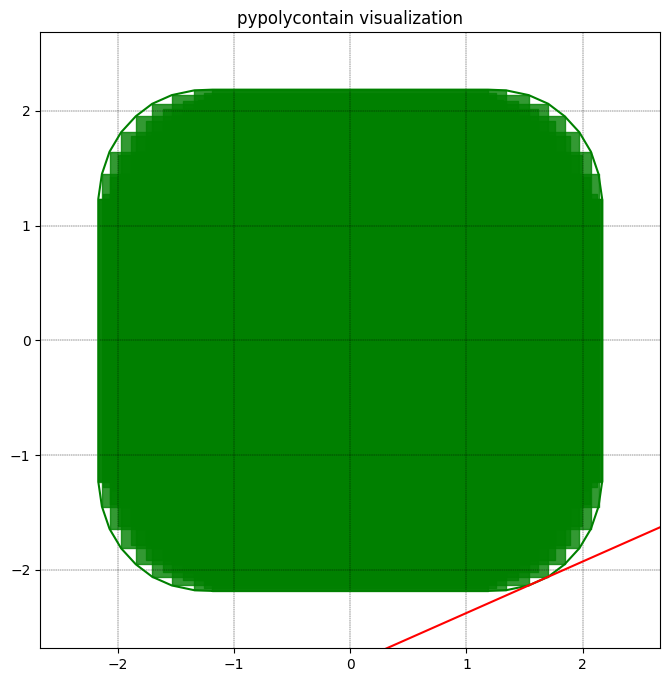

In [11]:
D = np.inf
for ab in halfspaces:
    a = np.array(ab[0])
    b = ab[1]
    if a.T @ zts_rob.x - b > 0:
        # print("The robot is outside the halfspace.")
        continue
    # D = |a^T * x - b| / ||a||
    if D > abs(a.T @ zts_rob.x - b) / np.linalg.norm(a):
        D = abs(a.T @ zts_rob.x - b) / np.linalg.norm(a)
        a_min = a
        b_min = b

try:
    pp.visualize(zts_obj)
except:
    pass
plt.plot(x,y,'g')
plt.plot([-10,10], [(b_min - a_min[0] * (-10)) / a_min[1], (b_min - a_min[0] * (10)) / a_min[1]], 'r')
plt.show()


Let's define our CBF! Remember, the safeset which we would like to render invariant (basically means if we are inside the set, we will remain in the set) is of the form

$\mathcal{C} = \left\{x \in \mathbb{R}^n \mid h\left(x, t\right) \geq 0 \right\}$

where our barrier function $h$ might depend explicitly on time. In our first scenario, however, we generate a constant CBF so there won't be any time dependencies.

In [12]:
h_static = lambda x, t: a_min.T @ x - b_min

## Control Synthesis!
Now that we've defined our CBF, we need to synthesize control inputs $u$ which render $\mathcal{C}$ invariant. Have a look at the lectures (or the linked paper) again and convince yourself that 

$\dot{h}\left(x, t\right) \geq - \gamma h\left(x, t\right)$

ensures invariance. By applying the chain rule to the above constraint, we can obtain an expression

$\dot{h}(x, t) = \frac{\partial h }{\partial x} \dot{x} + \frac{\partial h}{\partial t} = \frac{\partial h }{\partial x} (Ax + Bu + d) + \frac{\partial h}{\partial t} \geq -\gamma h(x, t)$

which is linear in the control input and, thus, this constraint can be included in convex optimization problems!

Basically, what we want to do now is to develop a safety filter that takes as input a reference control input $u_{ref}$, e.g. the LQR control input, and outputs a safe control input that satisfies the safety constraint. Additionally, this modified control input should be as close as possible to the reference input so that the robot follows its reference controller and the safety filter only intervenes if we're about to violate the safety specification. This can be formulated as an optimization problem

$$
\begin{aligned}
	\min_{u} \quad &(u - u_{ref})^T Q (u - u_{ref})\\
	\textrm{s.t.  } \quad  &\frac{\partial h }{\partial x} (Ax + Bu + d) + \frac{\partial h}{\partial t} \geq - \gamma h(x, t)
    \end{aligned}.
$$

which is a quadratic program (QP) and, thus, can be solved efficiently. For the following simulations simply assume that the robot disturbance is zero, i.e. $d=0$.

In order to solve the optimization problem, we will make use of python convex optimization package `cvxopt`. Please have a look at [this](https://cvxopt.org/examples/tutorial/qp.html) example of how to formulate and solve a QP in python. Hint: formulate the optimization using the decision variable $\tilde{u} = u - u_{ref}$ which requires slight modification of the safety constraint.

In [13]:
!pip install cvxopt
# Some imports for the CBF formulation
from scipy.integrate import odeint
from math import sin, cos, sqrt, atan2, pi
from cvxopt import matrix, solvers


[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


Let's define the function of the safety filter!

In [14]:
def safety_filter(x, h, t):
    gamma = 10
    # reference control input
    u_ref = -K @ x

    # Barrier condition dhdx * (f(x) + g(x) u) >= -h(x)
    dhdx = a_min.T
                
    dhdt = 0

    # set up QP:
    Q = matrix(2.0 * np.eye(2), tc='d')
    p = matrix(np.zeros(2), tc='d')
    G = matrix((-dhdx @ B).reshape(1, 2), tc='d')
    
    rhs = -gamma * h - dhdx @ (A @ x + B @ u_ref) - dhdt
    qp_constraint = matrix([float(rhs)], tc='d') 

    solvers.options['show_progress'] = False
    sol = solvers.qp(Q, p, G, qp_constraint)
    u_safe = np.array(sol['x']).flatten() + u_ref

    return u_safe 


Now we're gonna run a simple simulation which should show that the static halfspace constraint is always satisfied. To do so, we need to define the closed loop system and call a differential equation solver!

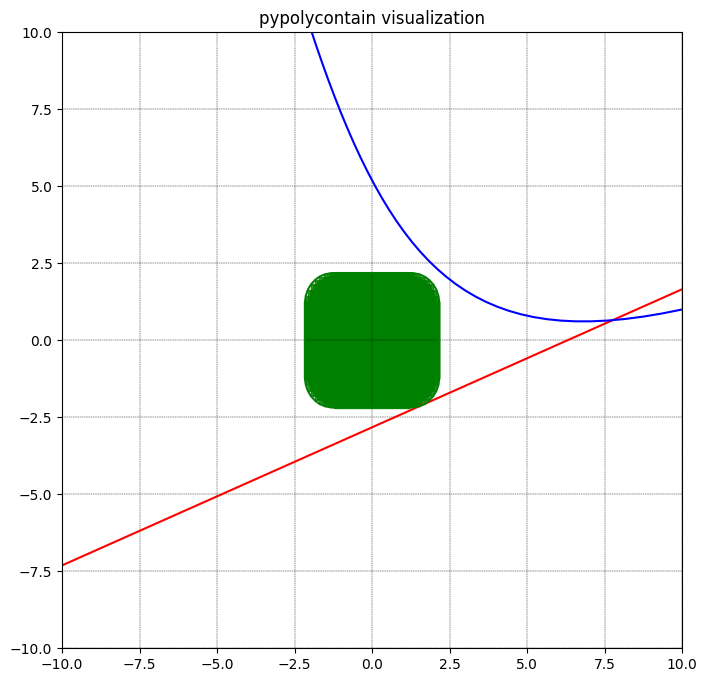

In [15]:
def closed_loop_system(x, t):
  # controller
  u = safety_filter(x, h_static(x, t), t)
  dx = np.dot(A, x) + np.dot(B, u)
  return dx

# Initial Conditions
t_sim = np.linspace(0, sim_duration, 300)


x_sol = odeint(closed_loop_system, c0, t_sim)

fig, ax = plt.subplots()

try:
  pp.visualize(zts_obj, fig=fig, ax=ax)
except:
  pass
ax.set_xlim([-10, 10])
ax.set_ylim([-10, 10])
plt.plot([-10,10], [(b_min - a_min[0] * (-10)) / a_min[1], (b_min - a_min[0] * (10)) / a_min[1]], 'r')
plt.plot(x,y,'g')
plt.plot(x_sol[:, 0], x_sol[:, 1], 'b')
plt.show()


## Let's see an animated version!
It might take a while to visualize.

Could not save animation with ffmpeg, trying pillow...
Could not save animation


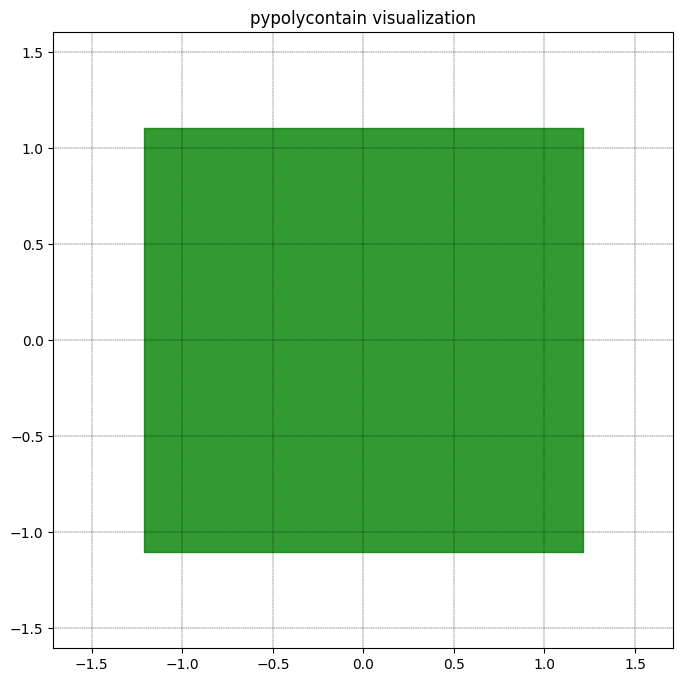

In [18]:
## ANIMATION FUNCTION
def animation_func(i,data):
  ax.clear()
  current_t = i * (sim_duration / len(t_sim))
  zts_obj = data[0]
  robot_pos = data[1]
  pp.visualize([zts_obj[min(len(zts_obj)-1, int(np.floor(current_t / r)))]], fig=fig, ax=ax)
  plt.plot(robot_pos[0:i, 0], robot_pos[0:i, 1], 'b')
  ax.set_xlim([-10, 11])
  ax.set_ylim([-10, 10])

fig = plt.figure()
ax = fig.add_subplot(111)
animation = FuncAnimation(fig,animation_func, fargs=((zts_obj,x_sol),),
                          frames=len(t_sim)-1, interval=50, blit=False)
HTML(animation.to_html5_video())

## Safe? yes! Is it what we want? No..
From this simulation we can observe that the robot indeed stays safe at all time, i.e. it does not collide with the dynamic obstacle. However, it is also rather conservative since the robot stays in the safe halfspace although the obstacle is far away. How can we change that? The key is to consider a timevarying control barrier function that changes whenever the obstacle is moving. In this section we will look into more sophisticated CBFs that will change over time. In this way, we will not only ensure safety but also ensure that our robot reaches its destination!

One requirement of a valid CBF is that it's continuous in time and continuously differentiable with respect to $x$ and $t$. Since we only have the obstacle zonotopes at discrete time steps, we will use a simple linear time interpolation for the obstacle between time steps $t_k$ and $t_{k+1}$.

The following function takes the current time as well as the list of discrete zonotopes and returns a polytope in vertex form (V_polytope) at the current time.

In [ ]:
def cont_time_obstacle(t, zonotopes_obst):
  # Use simple linear interpolation
  t_last =
  t_next =
  obst_last = 
  obst_next = 
  # obstacle at current time t as V-representation
  obst_t = 

  return obst_t



Now we have a function to call that provides us with a polytope representation of the obstacle at any time. However, we still need to ensure that our robot is always outside of the polytope. There are different ways to ensure collision avoidance, e.g. taking the distance between a point and a polygon. However, this would be a nonsmooth measure in $x$ which is why we consider an overapproximating circle in the following.

Find the smallest circle that contains the entire polytope at time t!

In [ ]:
def bounding_radius(t, zonotopes_obst):
  # Use simple linear interpolation
  ind = int(np.floor(t / r))
  t0 = ind * r
  t1 = (ind+1) * r
  
  # Zonotope centers
  z_c0 = zonotopes_obst[min(ind, len(zts_obj)-1)].x
  z_c1 = zonotopes_obst[min(ind+1, len(zts_obj)-1)].x


  # center of zonotope at time t
  z_c = z_c0 + ((z_c1 - z_c0) / (t1 - t0)) * (t - t0)

  r_bound = 

  return z_c, r_bound

# TEST
print(bounding_radius(1, zts_obj))

Let's check if our bounding circle algorithm works properly!

In [ ]:
from matplotlib.patches import Circle

fig, ax = plt.subplots()
try:
  pp.visualize(zts_obj, fig=fig, ax=ax)
except:
  pass
for i in range(len(zts_obj)):
  tnow = i * r
  center, radius = bounding_radius(tnow, zts_obj)
  ax.add_artist(Circle(center, radius, fill=False))
plt.show()

In the case of a CBF that explicitly depends on time, we need to to account for the known change of the obstacle over time. In this case, the explicit CBF time derivative $\frac{\partial h}{\partial t}$ is nonzero.

However, since the explicit time dependency is not exactly known in our case (as a result of discrete reachibility analysis and time interpolation), we approximate the time derivative of the barrier function using finite differences. To be specific, we will use a simple forward difference method

$\frac{\partial f}{\partial t} (t) \approx \frac{f\left(t + \delta t\right) - f\left(t\right)}{\delta t}$.

The CBF we consider is given as

$h(x, t) = \lVert x - c_{obs}(t) \rVert_2 - r_{obs}(t) \geq 0$

In the following, write a function that returns the value of the CBF $h(x, t)$, its gradient $\frac{\partial h}{\partial x}$ as well as its explicit time derivative $\frac{\partial h}{\partial t}$. Hint: you need to apply the chain rule for the gradient and the time derivative. Approximate explicit time derivatives $\frac{\partial c_{obs}}{\partial t}$ and $\frac{\partial r_{obs}}{\partial t}$ using finite differences.

In [ ]:
def cbf_dynamic(x, t):
  # Input: state defined as x = [x_robot, y_robot]
  # Output: Value of CBF h(x), gradient with respect to x dhdx(x), explicit time derivative dhdt

  return h_val, dhdx, dhdt


#Test
print(cbf_dynamic(c0, 0))

Now, we will define the safety filter similarly to the safety filter using the static CBF. Set up the QP and run the continuous time simulation. What can you observe? Try different parameter settings for $\gamma = [1, 10, 30]$. Also, plot the value of $h(x, t)$ over time for different values of $\gamma$. What is the trade-off when choosing large values of $\gamma$?

In [ ]:
def safety_filter(x, t):
  #PUT YOUR CODE HERE
  return u_safe

# closed loop dynamics including CBF controller
def closed_loop_system(x, t):
  #PUT YOUR CODE HERE
  return dx

# Initial Conditions
t_sim = np.linspace(0, sim_duration, 300)

x_sol = odeint(closed_loop_system, c0, t_sim)

fig = plt.figure() 
ax = fig.add_subplot(121)
try:
  pp.visualize(zts_obj, fig=fig, ax=ax)
except:
  pass
plt.plot(x_sol[:, 0], x_sol[:, 1], 'b')
ax.set_xlim([-10, 11])
ax.set_ylim([-10, 10])
ax2 = fig.add_subplot(122)
plt.plot(t_sim, [cbf_dynamic(x_sol[i], t_sim[i])[0] for i in range(len(t_sim))])
plt.show()


Lastly, we can see our robot in action! In this simulation section, you have been working on safe control synthesis in a reactive setting meaning that obstacle avoidance is guaranteed but it also could have been avoided at all if this problem would have been tackled at a higher level such as motion planning. Nonetheless, CBFs are an amazing tool for safety guarantees on a control level. There are many different topics that you could explore from here, e.g. robust CBFs, CBFs under uncertainties, CBFs for multi-agent systems, CBFs for safe reinforcement learning and many more!

In [ ]:
## ANIMATION FUNCTION
def animation_func(i,data):
  # visualize robot 
  robot_pos = data
  plt.plot([robot_pos[k][0] for k in range(i)], [robot_pos[k][1] for k in range(i)], 'b')
  
  current_t = i * (sim_duration / len(t_sim))
  
  # visualize obstacle set
  current_obs = cont_time_obstacle(current_t, zts_obj)
  conv_hull_obj = MultiPoint(current_obs).convex_hull
  x,y = conv_hull_obj.exterior.coords.xy
  poly_plot.set_xdata(x)
  poly_plot.set_ydata(y)

  c_obs, r_obs = bounding_radius(current_t, zts_obj)
  patch.center = c_obs
  patch.radius = r_obs

  ax.set_xlim([-10, 11])
  ax.set_ylim([-10, 10])
  
fig = plt.figure()
ax = fig.add_subplot(111)
conv_hull_obj = MultiPoint(cont_time_obstacle(0, zts_obj)).convex_hull
x,y = conv_hull_obj.exterior.coords.xy
poly_plot, = plt.plot(x, y, 'g')
plt.plot([c0[0]], [c0[1]], marker='o', markersize=4, c='r')

# Visualize circle
c_obs, r_obs = bounding_radius(0, zts_obj)
patch = Circle(c_obs, r_obs, fill=False)
ax.add_artist(patch)


animation = FuncAnimation(fig,animation_func, fargs=((x_sol),),
                          frames=len(x_sol), interval=50, blit=False)
HTML(animation.to_html5_video())